<a href="https://colab.research.google.com/github/dev-rafa1707/transfer_learning_dogs_vs_cats/blob/main/transfer_learning2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# WP de origem
# https://www.kaggle.com/code/hhp07022000/transfer-learning-the-cats-and-dogs/notebook
# https://www.tensorflow.org/datasets/catalog/cats_vs_dogs
# endereço atual da base de dados -- A base de dados foi adicionada ao google drive, é necessário ajustar o caminho de acesso em cada caso
# https://www.microsoft.com/en-us/download/details.aspx?id=54765

In [1]:
import urllib.request
import os
import zipfile
import random

import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from shutil import copyfile
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import warnings

warnings.filterwarnings('ignore')

In [3]:
#man, roda isso aqui substituindo o caminho pro do seu google drive pf
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!unzip "/content/drive/My Drive/kagglecatsanddogs_5340.zip" -d "/content/drive/My Drive/"

Mounted at /content/drive
Archive:  /content/drive/My Drive/kagglecatsanddogs_5340.zip
replace /content/drive/My Drive/PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
os.listdir('/content/drive/My Drive/PetImages/')

['Cat', 'Dog', 'cvd']

In [3]:
print("The number of Cat Images ", len(os.listdir('/content/drive/My Drive/PetImages/Cat')))
print("The number of Dog Images ", len(os.listdir('/content/drive/My Drive/PetImages/Dog')))

The number of Cat Images  12501
The number of Dog Images  12501


### Create new dir for training and validation images

In [6]:
try:
    os.mkdir('/content/drive/My Drive/PetImages/cvd/')
    os.mkdir('/content/drive/My Drive/PetImages/cvd/training')
    os.mkdir('/content/drive/My Drive/PetImages/cvd/testing')
    os.mkdir('/content/drive/My Drive/PetImages/cvd/training/cats')
    os.mkdir('/content/drive/My Drive/PetImages/cvd/training/dogs')
    os.mkdir('/content/drive/My Drive/PetImages/cvd/testing/cats')
    os.mkdir('/content/drive/My Drive/PetImages/cvd/testing/dogs')
except:
    print('error')

error


### Split the cats and dogs images for Training and Testing

In [8]:
def split_data(source, training, testing, split_size):
    files = []
    for filename in os.listdir(source):
        file = source + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(f'{filename} is corrupt or empty')
        
    training_length = int(len(files)* split_size)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[:training_length]
    testing_set = shuffled_set[training_length:]
    
    for filename in training_set:
        this_file = source + filename
        dest = training + filename
        copyfile(this_file, dest)
    
    for filename in testing_set:
        this_file = source + filename
        dest = testing + filename
        copyfile(this_file, dest)

cat_src_dir = '/content/drive/My Drive/PetImages/Cat/'
dog_src_dir = '/content/drive/My Drive/PetImages/Dog/'
training_cat_dir = '/content/drive/My Drive/PetImages/cvd/training/cats/'
training_dog_dir = '/content/drive/My Drive/PetImages/cvd/training/dogs/'
testing_cat_dir = '/content/drive/My Drive/PetImages/cvd/testing/cats/'
testing_dog_dir = '/content/drive/My Drive/PetImages/cvd/testing/dogs/'

split_size = 0.9

split_data(cat_src_dir, training_cat_dir, testing_cat_dir, split_size)
split_data(dog_src_dir, training_dog_dir, testing_dog_dir, split_size)

666.jpg is corrupt or empty
11702.jpg is corrupt or empty


### Resizing all the Image , just to visualize it in a neat manner

In [6]:
def resize_img(data_path):
    for filename in os.listdir(data_path):
        try:
            img = plt.imread(os.path.join(data_path, filename))
            img = cv.resize(img, (150, 150))
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            cv.imwrite(data_path+filename, img)
        except:
            continue

In [9]:
resize_img(training_cat_dir)
resize_img(training_dog_dir)
resize_img(testing_dog_dir)
resize_img(testing_dog_dir)

### Visualize the Provided images from our Training data drawn at random

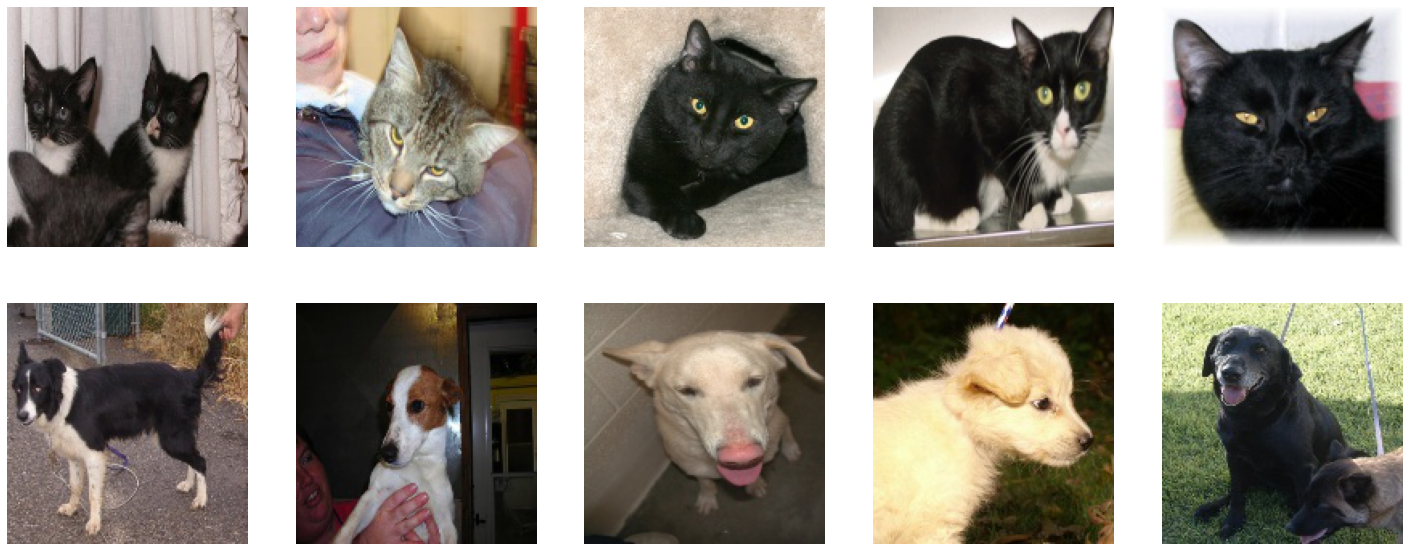

In [10]:
next_cat_pic = [os.path.join(training_cat_dir, fname) for fname in random.sample(os.listdir(training_cat_dir), 5)]
next_dog_pic = [os.path.join(training_dog_dir, fname) for fname in random.sample(os.listdir(training_dog_dir), 5)]

plt.figure(figsize=(25,10))
for i, img_path in enumerate(next_cat_pic + next_dog_pic):
    ax = plt.subplot(2, 5, i+1)
    ax.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img)

### Training InceptionV3 would eat up a day for training , so lets utilize GPU

In [11]:
gpus = tf.config.experimental.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
print('running on single gpu')

running on single gpu


### Data augmentation

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1/255.0, 
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1/255.0)

training_generator = train_datagen.flow_from_directory(
    '/content/drive/My Drive/PetImages/cvd/training/', 
    batch_size=100, 
    class_mode='binary', 
    target_size=(150, 150)
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/My Drive/PetImages/cvd/testing/', 
    batch_size=100, 
    class_mode='binary', 
    target_size=(150, 150)
)

Found 24769 images belonging to 2 classes.
Found 4745 images belonging to 2 classes.


### lets load the pretrained weights of inception_v3 so our training would be easy and gets well fit within few epochs

In [13]:
weights_url = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
weights_file = 'inception_v3.h5'
urllib.request.urlretrieve(weights_url, weights_file)

('inception_v3.h5', <http.client.HTTPMessage at 0x7f49a8c26bd0>)

### Get the InceptionV3 model from tensorflow.applications and Load the pretrained weights to the model and get the last layer alone for training to develop our model on top of a monster

In [14]:
with strategy.scope():
    pre_trained_model = InceptionV3(
        input_shape=(150, 150, 3), 
        include_top=False, 
        weights=None
    )
    pre_trained_model.load_weights(weights_file)

    for layer in pre_trained_model.layers:
        layer.trainable = False
    last_layer = pre_trained_model.get_layer('mixed7')
    print(last_layer.output_shape)
    last_output = last_layer.output

(None, 7, 7, 768)


### Creating our custom model on top inception_v3's last_layer to suit our model requirement for binary classification

In [15]:
def model(inputs):
    x = layers.Flatten()(inputs)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    model = Model(pre_trained_model.input, x)
    return model

with strategy.scope():
    model = model(last_output)
    model.compile(optimizer=ks.optimizers.RMSprop(lr=0.0001), loss='binary_crossentropy', metrics=['acc'])

### Creating a callback to end training after reaching 99% accuracy but I would just run for 50 epochs within that it won't get that much accuracy is my guess, even though our model would perform well

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('acc')>0.99):
            print('\nReached 99% accuracy so cancelling training')
            self.model.stop_training = True

callbacks = myCallback()

### Training the Gigantic model

In [17]:
# I tried diferent values for opech. In the original wp was 50, but I changed to 10. It took too much time.

In [ ]:
history= model.fit(training_generator, validation_data=validation_generator, epochs=10, verbose=0, callbacks=[callbacks])

### Visualizing How well this Big guy has learnt

In [ ]:
def plot_metrics(metric_name):
    train_loss = history.history[metric_name]
    epochs = range(len(train_loss))
    val_loss = history.history['val_' + metric_name]
    plt.figure(figsize=(5, 5))
    plt.plot(epochs, train_loss, color='r')
    plt.plot(epochs, val_loss, color='b')
    plt.title(f'Model {metric_name}')
    plt.legend([f'training_{metric_name}', f'val_{metric_name}'])
    plt.xlabel('epochs')
    plt.ylabel(f'{metric_name}')
    plt.show()

In [ ]:
plt.style.use('seaborn')
plot_metrics('loss')
plot_metrics('acc')

### Seeing the above visualization the model has both training and validation accuracy closer to 98% , And there is a lot of Noise seeing the visuals. Training was good where the accuracy seems to be growing inverted to the loss while the validation accuracy and loss has to drastic improvement compared to training. accuracy chart hides the models overfit while the loss chart clearly shows overfitting of the model

### Lets see how well our model predicts for some new data

In [ ]:
def predict_class(filename, model, ax):
    img = load_img(filename, target_size=(150, 150))
    image = plt.imread(filename)
    image = cv.resize(image, (200, 200))
    ax.imshow(image)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    img = img_to_array(img)
    img = img.reshape(1, 150, 150, 3)
    img = img.astype('float32')/255.0
    result = model.predict(img)
    if result[0][0] > 0.9:
        ax.set_title('Dog | Score: ' + str(result[0][0]))
    else:
        ax.set_title('Cat | Score: ' + str(result[0][0]))

In [ ]:
def urler(url, ax):
    resource = urllib.request.urlopen(url)
    output = open('file.jpg', 'wb')
    output.write(resource.read())
    output.close()
    predict_class('file.jpg', model, ax)

### So i got some images of cats and dogs from google

In [ ]:
url_list = [
    'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS3bCwUCJW0BlgvKzh5KvHTdbOQ3wGPcEUnMQ&usqp=CAU', 
    'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRviwTGt6wboCe9ajzBJDy4aJ19NmhNv4dg2g&usqp=CAU',
    'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRfNrh7pE_rneJlr31AhoLaGtZdX2qCBKV-EA&usqp=CAU',
    'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS9FhF-KCQL_pRcCYyOHlaWzYOL03QnvANbfw&usqp=CAU',
    'https://s3.ap-southeast-1.amazonaws.com/images.deccanchronicle.com/dc-Cover-kg8a727q0cuucunk15mpfv2uv2-20170725190600.Medi.jpeg',
    'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTNDH6Ggz1lwkaBTC4r3RqeF6KYTHuBNFE-bg&usqp=CAU', 
    'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRMFelkjsaJRYkSCRybp9szEDULwDffMKR-3g&usqp=CAU', 
    'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRxYAKQt_C0roPUU2-VYx6I_YKseX3hyOauQw&usqp=CAU', 
    'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRF8L1kksXIdsHlKTXyMHPCTfaxcu0CE9fIC2CX3Z4pO0mfKTv-n6d7FN-z6Rvlvs_AfwI&usqp=CAU', 
    'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRa__d0RbzBPaQrkrlg1E6ZLnz1EVHVB4dTMQ&usqp=CAU', 
    'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSEZ4n6vaYSFi8wNK1xNwiUNx969vRI7iS_A55O66dIdXNH2lxJSFTMwxjE-a-V2yyZAxA&usqp=CAU',  
    'https://www.pinkvilla.com/files/styles/amp_metadata_content_image_min_696px_wide/public/alia_bhatt_bids_goodbye_to_her_cat_sheeba_as_the_feline_passes_away_.jpg?itok=dNAseG1R', 
    'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT-k5F8HSK60Iwwj-x_kFFCg6anSVzWD_QFbA&usqp=CAU', 
    'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ2Zvsf9hVwYoI3JbCwnZvnI5Cjbjk76a74YA&usqp=CAU', 
    'https://blog.mystart.com/wp-content/uploads/shutterstock_288913766-e1551281043329.jpg', 
    'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR4pbDrhn-j_GvNBSIRA3ZZwOGa8etrh4qJ7YXGRg-FzwAyujZuKyP_2VHZMToV6HJy4XA&usqp=CAU'
    
]

In [ ]:
n = 0
fig = plt.figure(figsize=(22, 20))
axs = fig.subplots(4, 4)
for i in range(4):
    urler(url_list[n+0], axs[i, 0])
    urler(url_list[n+1], axs[i, 1])
    urler(url_list[n+2], axs[i, 2])
    urler(url_list[n+3], axs[i, 3])
    n += 4
plt.tight_layout()
plt.show()

### The results from this model are great, it predicted super fine to these images, As I intendedly chose some images where it would fall as prey but it survived. We can further Visualize how the model identified it to be a cat using saliency maps later

In [ ]:
model.save('cats_vs_dogs_IV3.h5')